# Setup

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
import torch
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import F1Score
import pandas as pd

# Run

### Try the model

In [2]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis", ignore_mismatched_sizes=True)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.1f}M")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/568M [00:00<?, ?B/s]

Total number of parameters: 141.9M


In [3]:
def test_1(input_text):
  # Tokenize input and get model output
  inputs = tokenizer(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = model(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probs = softmax(logits, dim=1)

  # Map classes to polarity values
  polarity_values = torch.tensor([-1.0, 0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
  polarity_score = torch.sum(probs * polarity_values, dim=1).item()

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  print(f"Predicted class: {predicted_class}")
  print(f"Polarity score: {polarity_score:.2f}")

# Positive class
input_text = "The Bitcoin market will continue to grow"
test_1(input_text)

# Neutral class
input_text = "The Bitcoin market will remain steady"
test_1(input_text)

# Negative class
input_text = "The Bitcoin market is trending down"
test_1(input_text)

Predicted class: 2
Polarity score: 0.98
Predicted class: 2
Polarity score: 0.88
Predicted class: 0
Polarity score: -1.00


### Fine tune the model

In [4]:
# Set a fixed random seed for reproducibility
random.seed(42)

# Load the dataset from Hugging Face
dataset = load_dataset("kisejin/finance_sentiment_dataset")

# Convert string labels to integers
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}

# Split data by sentiment label
negative_samples = [sample for sample in dataset["train"] if sample["output"] == "negative"]
positive_samples = [sample for sample in dataset["train"] if sample["output"] == "positive"]
neutral_samples = [sample for sample in dataset["train"] if sample["output"] == "neutral"]

# Get the number of negative samples to balance
num_samples = 3000 # len(negative_samples)

# Randomly select same number of positive and neutral samples
balanced_negative_samples = random.sample(negative_samples, num_samples)
balanced_positive_samples = random.sample(positive_samples, num_samples)
balanced_neutral_samples = random.sample(neutral_samples, num_samples)

# Combine all into a new dataset
balanced_dataset = balanced_negative_samples + balanced_positive_samples + balanced_neutral_samples

# Convert 'output' field to integers
for sample in balanced_dataset:
    sample['output'] = label_mapping[sample['output']]

# Optional: Convert it to a Hugging Face dataset for compatibility
from datasets import Dataset
balanced_dataset = Dataset.from_dict({k: [d[k] for d in balanced_dataset] for k in balanced_dataset[0].keys()})

#### Trial #1

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2700 [03:59<?, ?it/s]


Epoch 1/3: train loss 0.4750, val loss 0.3584, val f1 score 0.8622


Epoch 2/3: train loss 0.3015, val loss 0.3087, val f1 score 0.8974


Epoch 3/3: train loss 0.2285, val loss 0.3000, val f1 score 0.9013


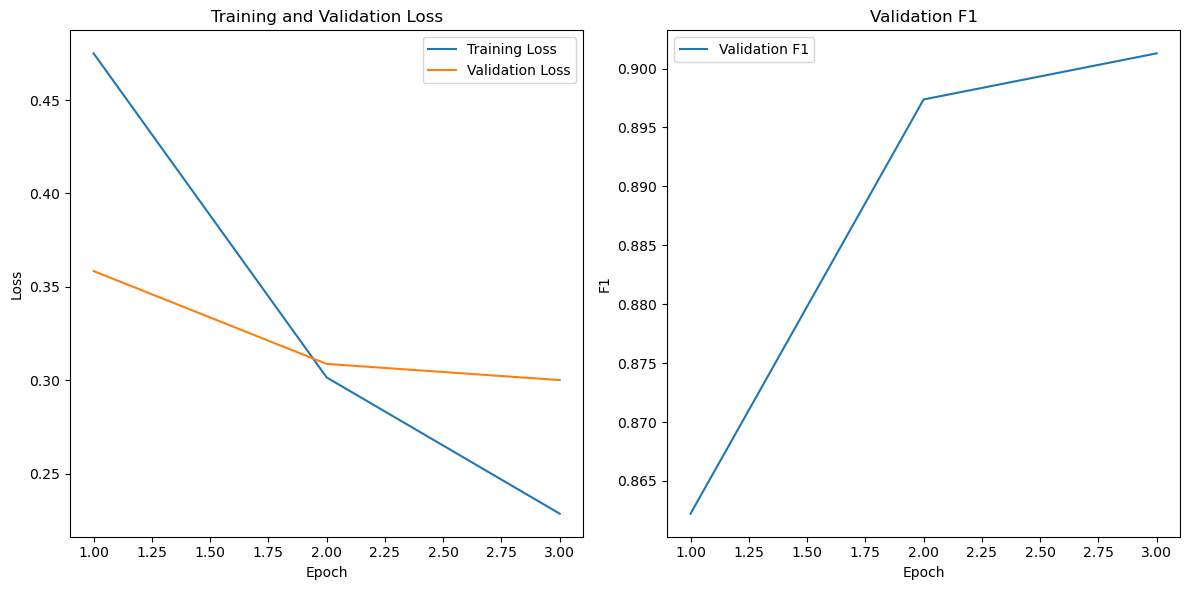

Final validation F1: 0.9013


In [11]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis", ignore_mismatched_sizes=True)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True, max_length=512)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-6)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_f1_scores = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric = F1Score(task="multiclass", num_classes=3, average="weighted").to(device)

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_f1 = f1_metric.compute().item()
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val f1 score {val_f1_scores[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_f1_scores)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores[-1]:.4f}")

In [13]:
modelsavename = "deberta_9k_ep3_9013.pt"

# Save the model's state_dict
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

print(f"Model saved as {modelsavename}")

Model saved as deberta_9k_ep3_9013.pt


In [ ]:
# # Tokenize the input text in the dataset
# tokenized_samples = tokenizer(balanced_dataset["input"], padding=True, truncation=True)

# # Calculate lengths of input_ids
# lengths = [len(sample) for sample in tokenized_samples['input_ids']]

# # Print out the maximum length
# max_length = max(lengths)
# print("Maximum token length in the dataset:", max_length)


Maximum token length in the dataset: 183
